**Gabriela Tanumihardja**</br>
**Capstone Project - Part VII** </br>
**Deep Learning - BERT multilabel**

I will now adapt the previous model to fit a multilabel problem. I will attempt to predict the source of the headlines. As stated previously, this code is adapted from Google's sample code under Apache License v2.0.

https://colab.research.google.com/github/bentoml/gallery/blob/master/tensorflow/bert/bert_movie_reviews.ipynb#scrollTo=dCpvgG0vwXAZ</br>
http://www.apache.org/licenses/LICENSE-2.0

In [15]:
!pip install -q tqdm bert-for-tf2

In [16]:
import os
import sys
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from tensorflow import keras
import re

In [17]:
# check versions

print("Tensorflow: ", tf.__version__)
print("Python: ", sys.version)
print("GPU: ", tf.test.is_gpu_available())
assert sys.version_info.major == 3 and sys.version_info.minor == 6  # required by clipper benchmark

Tensorflow:  2.3.0
Python:  3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
GPU:  True


In [19]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# load in data

train_df = pd.read_csv('/content/drive/My Drive/CAPSTONE/BERT/multi/train_multi.csv')
test_df = pd.read_csv('/content/drive/My Drive/CAPSTONE/BERT/multi/test_multi.csv')

I will follow the exact same method as previous BERT model fine tuning... I will use the label column as source_code instead.

In [21]:
class NewsData:
    DATA_COLUMN = "title"
    LABEL_COLUMN = "source_code"
    
    def __init__(self, tokenizer: FullTokenizer, sample_size=None, max_seq_len=1024):
        self.tokenizer = tokenizer
        self.sample_size = sample_size
        self.max_seq_len = 0

        train, test = train_df, test_df
        
        train, test = map(lambda df: df.reindex(df[NewsData.DATA_COLUMN].str.len().sort_values().index), 
                          [train, test])
                
        if sample_size is not None:
            train, test = train.head(sample_size), test.head(sample_size)
            # train, test = map(lambda df: df.sample(sample_size), [train, test])
        
        ((self.train_x, self.train_y),
         (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        ((self.train_x, self.train_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, 
                                                       [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[NewsData.DATA_COLUMN], row[NewsData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)


I have downloaded base BERT model onto my Google drive. It was downloaded from:
https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip </br>
I will now load in the pre-trained model.

In [22]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("/content/drive/My Drive/CAPSTONE/BERT/model", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

#### Data Preprocessing

I will now put through all my data through the tokenizer. I will use a maximum of 128 tokens, or lower if my data's actual max sequence is lower than 128. I will also use all of my training data.

In [23]:
%%time

tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
data = NewsData(tokenizer,
                       max_seq_len=128)

100%|██████████| 9.57k/9.57k [00:03<00:00, 3.13kit/s]
100%|██████████| 2.39k/2.39k [00:00<00:00, 3.16kit/s]


max seq_len 66
CPU times: user 4.04 s, sys: 40.7 ms, total: 4.08 s
Wall time: 4.09 s


In [24]:
print("            train_x", data.train_x.shape)
print("train_x_token_types", data.train_x_token_types.shape)
print("            train_y", data.train_y.shape)

print("             test_x", data.test_x.shape)

print("        max_seq_len", data.max_seq_len)

            train_x (9568, 66)
train_x_token_types (9568, 66)
            train_y (9568,)
             test_x (2392, 66)
        max_seq_len 66


The data's max_seq_len is 66 words, so that's what will be used in the model training. I will be training the entire BERT layers with my data, so the I will not be using the freeze_bert_layer function. For training, a learning rate scheduler will also be instantiated. A warm up phase will also be instantiated. Initally the training rate will be higher, making larger changes, and reduce per epoch, making finer adjustments.

In [25]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False


def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
        else:
            res = max_learn_rate*math.exp(
                math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler


From here I will assemble my model, and add a layer of softmax to give the final classification probability. This function will also load the the pre-trained BERT model. Finally the function will return the compiled model.

In [26]:
def create_model(max_seq_len, adapter_size=64):
    """Creates a classification model."""

    # create the bert layer
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = adapter_size
        bert = BertModelLayer.from_params(bert_params, name="bert")

    input_ids      = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    output         = bert(input_ids)

    print("bert shape", output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=4, activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    # load the pre-trained model weights
    load_stock_weights(bert, bert_ckpt_file)

    # freeze weights if adapter-BERT is used
    if adapter_size is not None:
        freeze_bert_layers(bert)

    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    model.summary()

    return model

Compiling model

In [27]:
adapter_size = None 
model = create_model(data.max_seq_len, adapter_size=adapter_size)

bert shape (None, 66, 768)
Done loading 196 BERT weights from: /content/drive/My Drive/CAPSTONE/BERT/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fba3a293f28> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 66)]              0         
_________________________________________________________________
bert (Bert

In [28]:
%%time

log_dir = ".log/satire_pred/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

total_epoch_count = 20
history = model.fit(x=data.train_x, y=data.train_y,
          validation_split=0.1,
          batch_size=12,
          shuffle=True,
          epochs=total_epoch_count,
          callbacks=[create_learning_rate_scheduler(max_learn_rate=1e-5,
                                                    end_learn_rate=1e-7,
                                                    warmup_epoch_count=20,
                                                    total_epoch_count=total_epoch_count),
                     keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                     tensorboard_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 5.000000000000001e-07.
Epoch 1/30
718/718 [==============================] - 296s 413ms/step - loss: 1.3904 - acc: 0.2763 - val_loss: 1.3548 - val_acc: 0.3511

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 2/30
718/718 [==============================] - 292s 406ms/step - loss: 1.3279 - acc: 0.3793 - val_loss: 1.1921 - val_acc: 0.5298

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5000000000000002e-06.
Epoch 3/30
718/718 [==============================] - 289s 402ms/step - loss: 1.2468 - acc: 0.4821 - val_loss: 1.0883 - val_acc: 0.6583

Epoch 00004: LearningRateScheduler reducing learning rate to 2.0000000000000003e-06.
Epoch 4/30
718/718 [==============================] - 291s 405ms/step - loss: 1.1833 - acc: 0.5492 - val_loss: 1.0589 - val_acc: 0.6928

Epoch 00005: LearningRateScheduler reducing learning rate to 2.5000000000000006e-06.
Epoch 5/30
718/718 [=======

The result of the training is quite good at 83% validation accuracy. I will now plot the loss vs epoch and accuracy vs epoch to evaluate the training process.

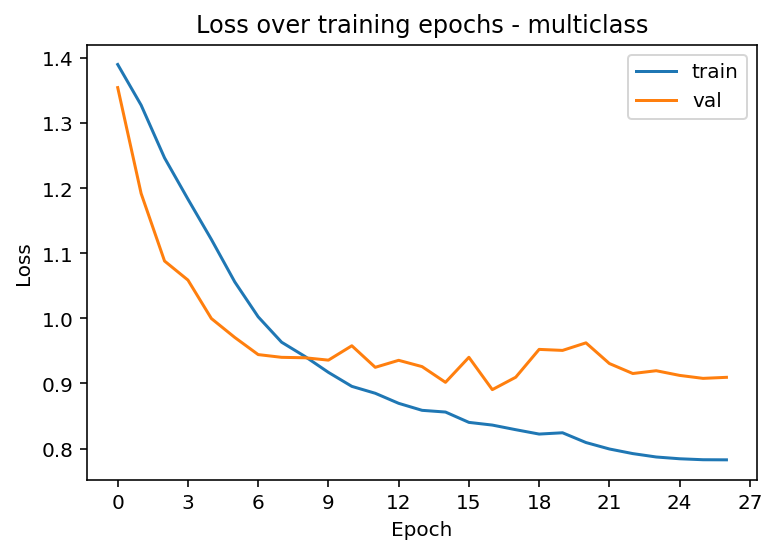

In [70]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs - multiclass')
plt.show();

The train loss decrease dramatically during the first few epochs, however levels at around epoch 12, however the validation loss stabilizes at around epoch 6.

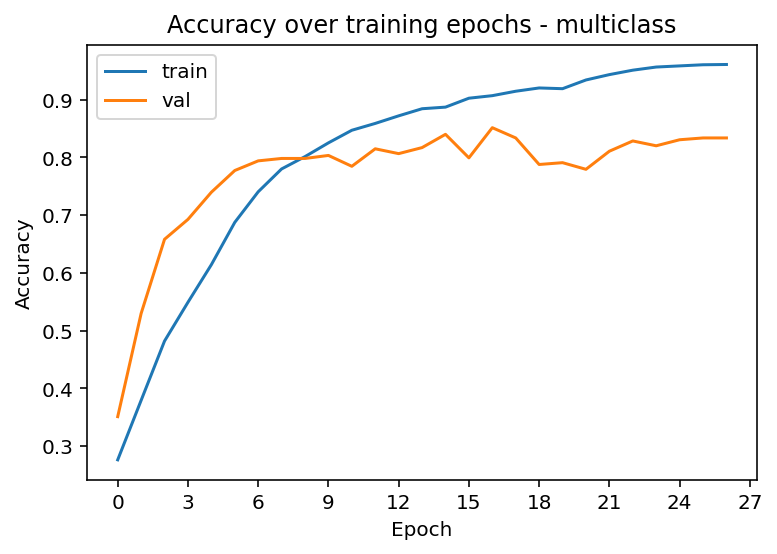

In [69]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Accuracy over training epochs - multiclass')
plt.show();

Training accuracy increased and started leveling off at around epoch 12, however validation accuracy plateaus around epoch 7. I will now evaluate the test accuracy.

In [32]:
%%time

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print(" test acc", test_acc)

75/75 [==============================] - 13s 168ms/step - loss: 0.9451 - acc: 0.7968
train acc 0.9274665713310242
 test acc 0.796822726726532
CPU times: user 36.2 s, sys: 19.4 s, total: 55.7 s
Wall time: 1min 3s


The test accuracy stands at 80%, which is lower than the train accuracy of 93%. There is a possibility that this model may have been overfitted slightly, however it's not too much overfitted. I will now save the trained weights for use later.

In [33]:
# save weights

model.save_weights('/bert_multi.h5', overwrite=True)

In [34]:
# load model

loaded_model = create_model(data.max_seq_len, adapter_size=None)
loaded_model.load_weights("/bert_multi.h5")

bert shape (None, 66, 768)
Done loading 196 BERT weights from: /content/drive/My Drive/CAPSTONE/BERT/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fb92460eb70> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 66)]              0         
_________________________________________________________________
bert (Bert

In [35]:
# I will run the test set with the loaded model

%%time 

_, test_acc = loaded_model.evaluate(data.test_x, data.test_y)

print(" test acc", test_acc)

75/75 [==============================] - 12s 166ms/step - loss: 0.9451 - acc: 0.7968
 test acc 0.796822726726532
CPU times: user 14.5 s, sys: 1.65 s, total: 16.2 s
Wall time: 31.2 s


We have the exact same results from the loaded model as the original model. I will now evaluate the model by creating a classification report and confusion matrix. I will use the test set to create these evaluations.

In [59]:
# make prediction on test set

y_pred = loaded_model.predict(data.test_x).argmax(axis=-1)

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72       519
           1       0.86      0.84      0.85       673
           2       0.74      0.81      0.77       600
           3       0.78      0.86      0.82       600

    accuracy                           0.80      2392
   macro avg       0.80      0.79      0.79      2392
weighted avg       0.80      0.80      0.80      2392



In [61]:
group = train_df.source.unique().tolist()

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=group, columns=group)

In [67]:
%config InlineBackend.figure_format='retina'

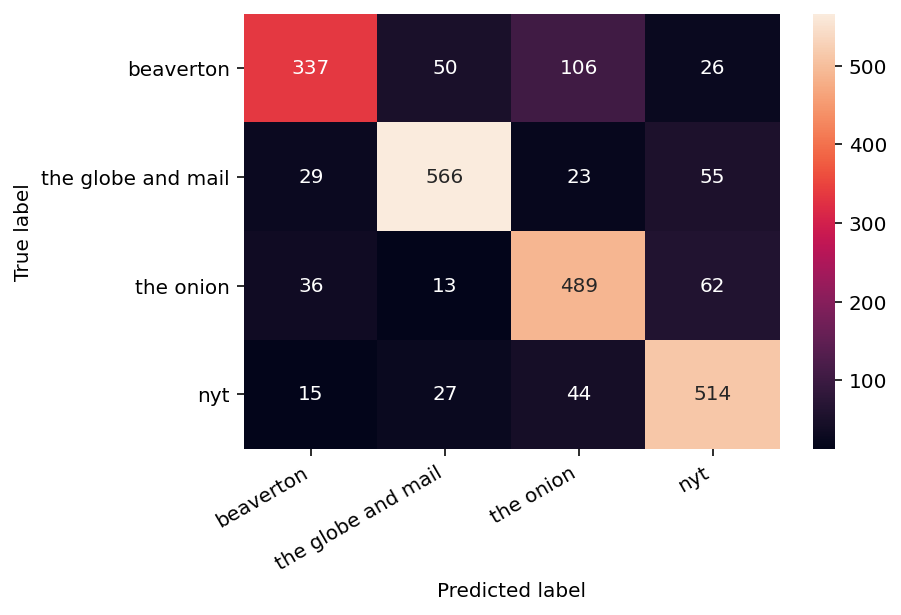

In [68]:
import seaborn as sns

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(["beaverton","the globe and mail", 'the onion', 'nyt'], rotation=0, ha='right')
hmap.xaxis.set_ticklabels(["beaverton","the globe and mail", 'the onion', 'nyt'], rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

From the confusion matrix above, it can be seen that, while the model is very good at identifying legitimate headlines, it has a problem identifying beaverton articles frm the oinion, specifically it keeps mistaking beaverton articles as onion's. It is somewhat expected as they are both North American's largest satirical news source and often share similar headlines.</br>
From here, I would like to be able to insert custom sentences into our model. The following code will tokenize, make a [CLS] [SEP] sandwhich, convert tokens to IDs, and feed these tokens into the loaded model. 

In [64]:
%%time
CLASSES = ["beaverton","the globe and mail", 'the onion', 'nyt']
max_seq_len = 128
pred_sentences = [
  "premier ford outraged federal government not doing his job",
  "vancouver experiencing severe mothman infestation",
  "most of B.C. now warned of smoky skies and lower air quality from U.S. wildfires",
  "17 dead and dozens missing as western wildfires rage",
]

inputs = pd.DataFrame(pred_sentences)

pred_tokens    = map(tokenizer.tokenize, inputs.to_numpy()[:, 0].tolist())
pred_tokens    = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(lambda tids: tids + [0] * (max_seq_len-len(tids)), pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

res = loaded_model(pred_token_ids).numpy().argmax(axis=-1)
print([CLASSES[i] for i in res])

['beaverton', 'beaverton', 'the globe and mail', 'nyt']
CPU times: user 126 ms, sys: 4.03 ms, total: 130 ms
Wall time: 133 ms


Good prediction! I will now save this model for easy loading.

In [81]:
model.save('/content/drive/My Drive/CAPSTONE/final_multi_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CAPSTONE/final_multi_model/assets
